# Logistic Regression for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [0]:
import pandas as pd
# if you want to download the original file:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"I've expected a comedy about the NVA, but this...",0
49996,Jamie Foxx was the epitome of Ray Charles. Aft...,1
49997,The last couple of weeks in the life of a dead...,0
49998,"(No need to recap the plot, since others have ...",1
49999,The movie starts quite with an intriguing scen...,0


Let us shuffle the class labels.

In [0]:
import numpy as np
## uncomment these lines if you have dowloaded the original file:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)
df.head()

,review,sentiment
11841,Not worth the video rental or the time or the ...,0
19602,I would recommend this for anyone who is an ad...,1
45519,This film is about two female killers going on...,0
25747,The film is a pathetic attempt to remake Ingma...,0
42642,What a trip down memory lane.<br /><br />Do no...,1


<br>
<br>

# Preprocessing Text Data



## Tokenizació**n** y conversión a Secuencias de cada Review

In [0]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=2000, split=' ')

data = pd.read_csv('shuffled_movie_data.csv')
tokenizer.fit_on_texts(data['review'])
X = tokenizer.texts_to_sequences(data['review'])

## Adheriendo padding a cada review tokenizado

In [0]:
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X)
Y = data['sentiment']

## Separando los datos de Entrenamiento y Testing

In [0]:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation  import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print('X_train.shape: ', X_train.shape)
print('Y_train.shape: ', Y_train.shape)
print('X_test.shape: ', X_test.shape)
print('Y_test.shape: ', Y_test.shape)

# Learning (Keras)

## Creación del Modelo

In [0]:
# !pip install keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

model = Sequential()

## Capa de Embedding

In [0]:
model.add( Embedding(2000, 32, input_length = X.shape[1], dropout=0.2))

## Primera Capa LSTM Bidireccional

In [0]:
model.add(Dropout(0.2))
model.add( Bidirectional( LSTM(20, return_sequences=True)))

## Segunda Capa LSTM Bidireccional

In [0]:
model.add(Dropout(0.2))
model.add( Bidirectional( LSTM(20)))

## Capa Final de Salida

In [0]:
model.add(Dropout(0.2))
model.add( Dense(1, activation = 'sigmoid'))

## Compilación y Resumen del Modelo

In [0]:
model.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics = ['accuracy'])
model.summary()

<br>
<br>

# Entrenamiento:

In [0]:
model.fit(X_train, Y_train, epochs = 3, batch_size = 512, verbose = 2)

<br>
<br>
# Predicción usando los Datos de Testing:

In [0]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

## Graphics of Cost vs Iterations over each batch

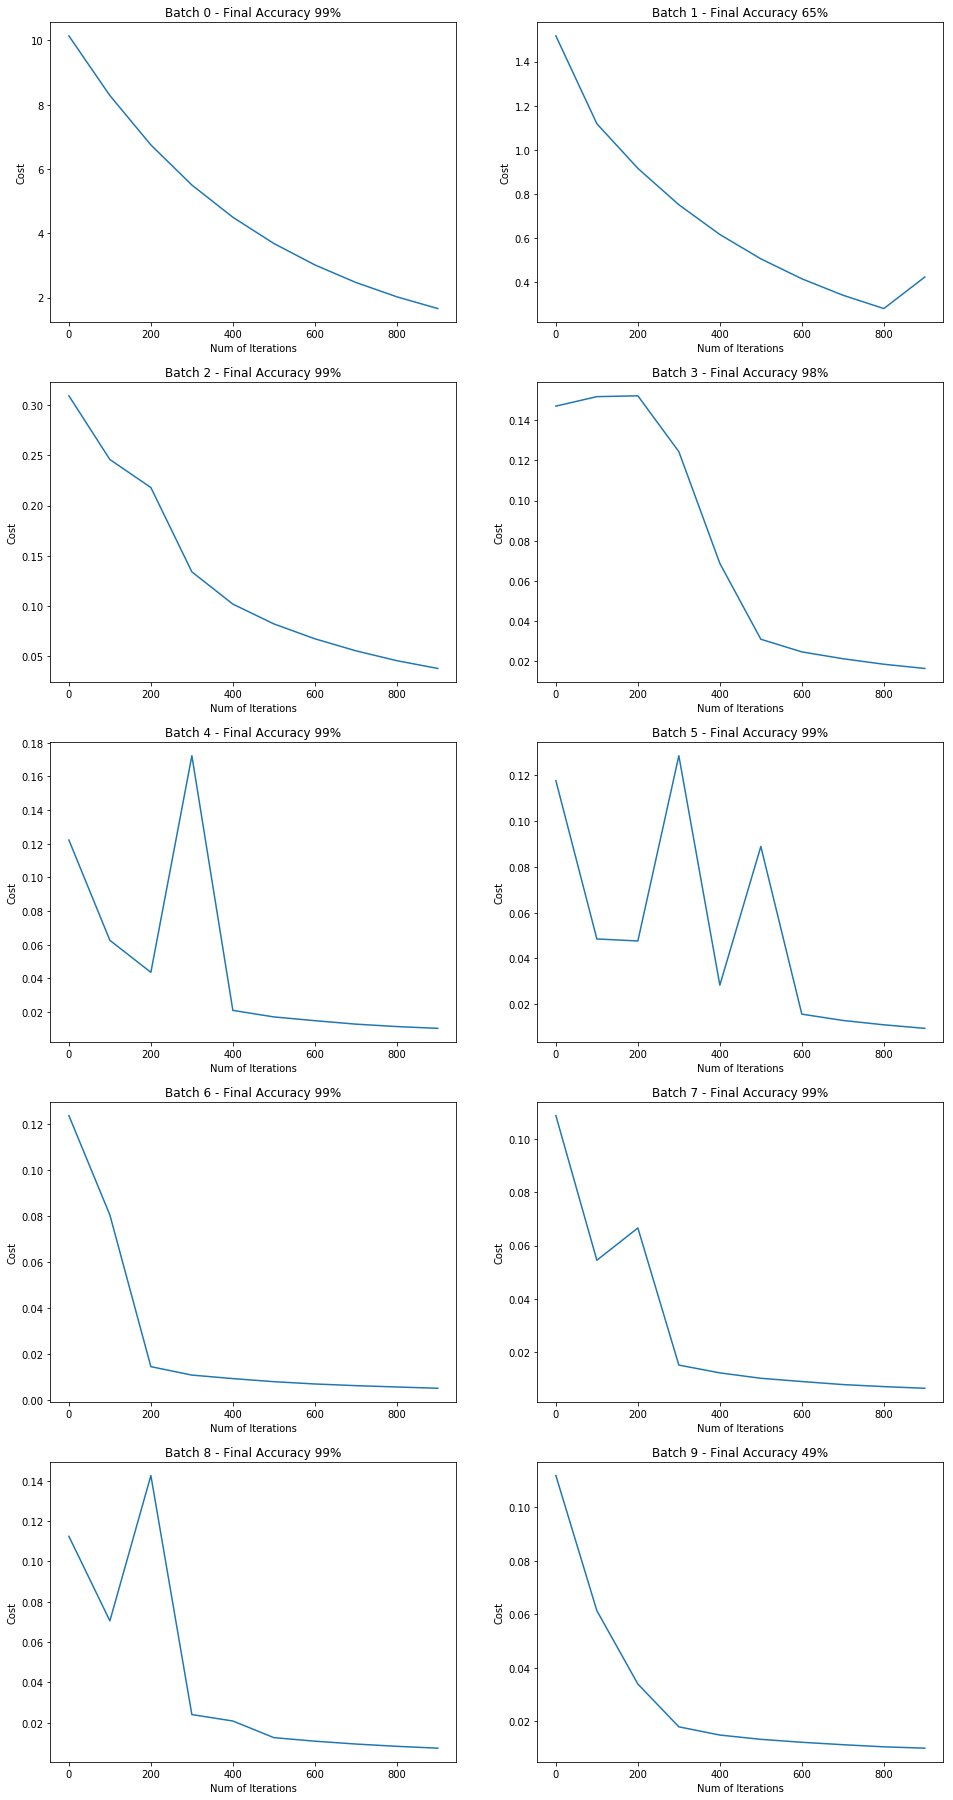

In [0]:
plt.figure(figsize=(16, 32))
for i, other in enumerate(d['costs']):
    plt.subplot(5, 2, i+1)
    
    cost    = d['costs'][i]
    iteration = [c*100 for c in range(len(cost))]
    accuracy  = d['accuracies'][i]*100
    
    plt.title('Batch %d - Final Accuracy %d%%' % (i, accuracy))
    plt.xlabel('Num of Iterations')
    plt.ylabel('Cost')
    
    plt.plot(iteration, cost)
plt.show()

<br>
<br>